In [17]:
from keras.models import Model
from keras.layers import Lambda, Input, Dense, Dropout
from keras.constraints import unit_norm
from keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.losses import mean_squared_error as mse
from keras.losses import binary_crossentropy
import tensorflow as tf

import pandas as pd
import numpy as np
import xarray as xr

from math import ceil
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import clustering_functions as cf
import xesmf as xe

In [2]:
execfile('pre_processing.py')

**import model specifications saved in yaml file**

In [3]:
import yaml
from yaml import CLoader as Loader
stream = open("model_specifications/R-VAE/v2.yaml", 'r')
dictionary = yaml.load(stream, Loader=Loader)

filepath = dictionary['filepath']

original_dim = dictionary['original_dim']
inputdim1 = dictionary['inputdim1']
inputdim2 = dictionary['inputdim2']

latent_dim = dictionary['latent_dim']
activation_function = dictionary['activation_function']

dim_layer1 = dictionary['dim_layer1']
dim_layer2 = dictionary['dim_layer2']
dim_layer3 = dictionary['dim_layer3']

batch_size = dictionary['batch_size']
epochs = dictionary['epochs']

reconstruction_loss_factor = dictionary['reconstruction_loss_factor']

In [4]:
input_shape_x = (original_dim, )
input_shape_r = (1, )

print('Input shape:', input_shape_x)
print('Input shape:', input_shape_r)

Input shape: (286,)
Input shape: (1,)


**Define sampling function**

In [5]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_sigma) * epsilon

### Define R-VAE model

**Encoder**

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 encoder_intermediate (Dens  (None, 128)                  36736     ['encoder_input[0][0]']       
 e)                                                                                               
                                                                                                  
 encoder_intermediate_2 (De  (None, 64)                   8256      ['encoder_intermediate[0][0]']
 nse)                                                                                             
                                                                                            

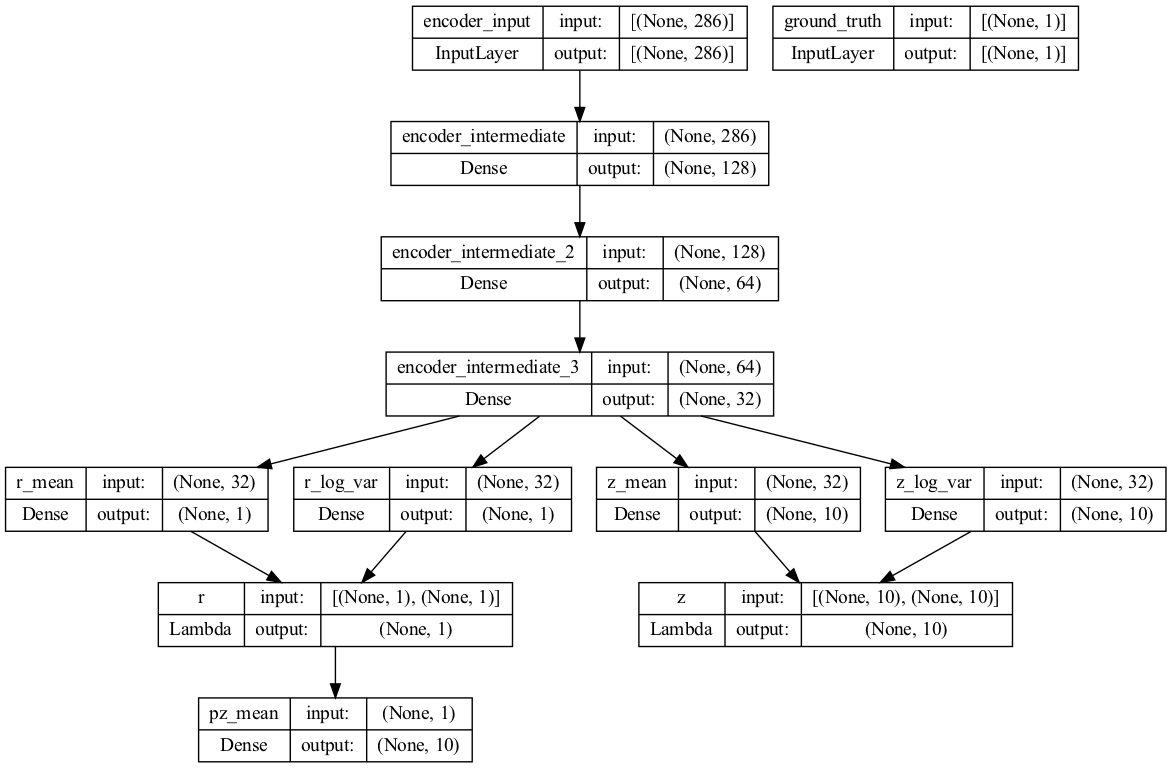

In [8]:
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')

inter_x1 = Dense(dim_layer1, activation=activation_function, name='encoder_intermediate')(inputs_x)
inter_x2 = Dense(dim_layer2, activation=activation_function, name='encoder_intermediate_2')(inter_x1)
inter_x3 = Dense(dim_layer3, activation=activation_function, name='encoder_intermediate_3')(inter_x2)

r_mean = Dense(1, name='r_mean')(inter_x3)
r_log_var = Dense(1, name='r_log_var')(inter_x3)

z_mean = Dense(latent_dim, name='z_mean')(inter_x3)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x3)

# reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(r)

# encoder model
encoder = Model([inputs_x,inputs_r], [z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean], name='encoder')
encoder.summary()
plot_model(encoder, show_shapes=True, dpi=300)
plot_model(encoder, to_file=filepath+'encoder_graph.png', show_shapes=True, dpi=100)

#### Decoder

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 286)               36894     
                                                                 
Total params: 47678 (186.24 KB)
Trainable params: 47678 (186.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


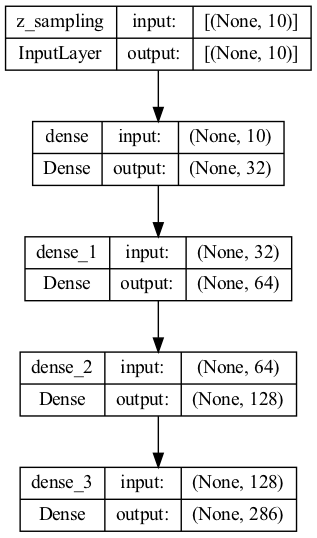

In [9]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(dim_layer3, activation=activation_function)(latent_inputs)
inter_y2 = Dense(dim_layer2, activation=activation_function)(inter_y1)
inter_y3 = Dense(dim_layer1, activation=activation_function)(inter_y2)
outputs = Dense(original_dim)(inter_y3)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, show_shapes=True, dpi=80)
plot_model(decoder, to_file=filepath+'decoder_graph.png', show_shapes=True, dpi=100)

**combine encoder and decoder to VAE model and print summary**

In [10]:
outputs = decoder(encoder([inputs_x,inputs_r])[2])
vae = Model([inputs_x,inputs_r], outputs, name='vae_regression')
vae.summary()

Model: "vae_regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 47818     ['encoder_input[0][0]',       
                              (None, 10),                            'ground_truth[0][0]']        
                              (None, 10),                                                         
                              (None, 1),                                             

**Define loss function**

In [19]:
reconstruction_loss = mse(inputs_x,outputs)*original_dim*reconstruction_loss_factor

kl_loss = 1 + z_log_var - K.square(z_mean-pz_mean) - K.exp(z_log_var)
kl_loss = -0.5*K.sum(kl_loss, axis=-1)

label_loss = (tf.divide(0.5*K.square(r_mean - inputs_r), K.exp(r_log_var)) +  0.5 * r_log_var)
vae_loss = K.mean(reconstruction_loss+kl_loss+label_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.save_weights(filepath+'random_weights.h5')

Model: "vae_regression"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 286)]                0         []                            
                                                                                                  
 ground_truth (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 47818     ['encoder_input[0][0]',       
                              (None, 10),                            'ground_truth[0][0]']        
                              (None, 10),                                                         
                              (None, 1),                                             

**Prepare data**

In [20]:
X = cf.reshape_data_for_clustering(z500)
y = pr_boxcox_spatial

X_train_1, X_test_1, y_train, y_test = train_test_split(z500.values, y, test_size=0.33)

nt,ny,nx = X_train_1.shape
X_train = np.reshape(X_train_1, [nt, ny*nx], order='F')

nt,ny,nx = X_test_1.shape
X_test = np.reshape(X_test_1, [nt, ny*nx], order='F')

**Evaluate convergence of loss function on test-train data split**

In [21]:
vae.load_weights(filepath+'random_weights.h5')
history = vae.fit([X_train,y_train], [X_train,y_train], epochs=epochs, batch_size=batch_size, validation_data=([X_test,y_test], [X_test,y_test]))

Epoch 1/100
132/132 [==============================] - 1s 3ms/step - loss: 18.6137 - val_loss: 13.9404
Epoch 2/100
132/132 [==============================] - 0s 2ms/step - loss: 12.5973 - val_loss: 11.6406
Epoch 3/100
132/132 [==============================] - 0s 2ms/step - loss: 11.4617 - val_loss: 11.0521
Epoch 4/100
132/132 [==============================] - 0s 2ms/step - loss: 11.0283 - val_loss: 10.7393
Epoch 5/100
132/132 [==============================] - 0s 2ms/step - loss: 10.7247 - val_loss: 10.5934
Epoch 6/100
132/132 [==============================] - 0s 2ms/step - loss: 10.5168 - val_loss: 10.4096
Epoch 7/100
132/132 [==============================] - 0s 2ms/step - loss: 10.4275 - val_loss: 10.3992
Epoch 8/100
132/132 [==============================] - 0s 2ms/step - loss: 10.3646 - val_loss: 10.3296
Epoch 9/100
132/132 [==============================] - 0s 2ms/step - loss: 10.2523 - val_loss: 10.2436
Epoch 10/100
132/132 [==============================] - 0s 2ms/step - los

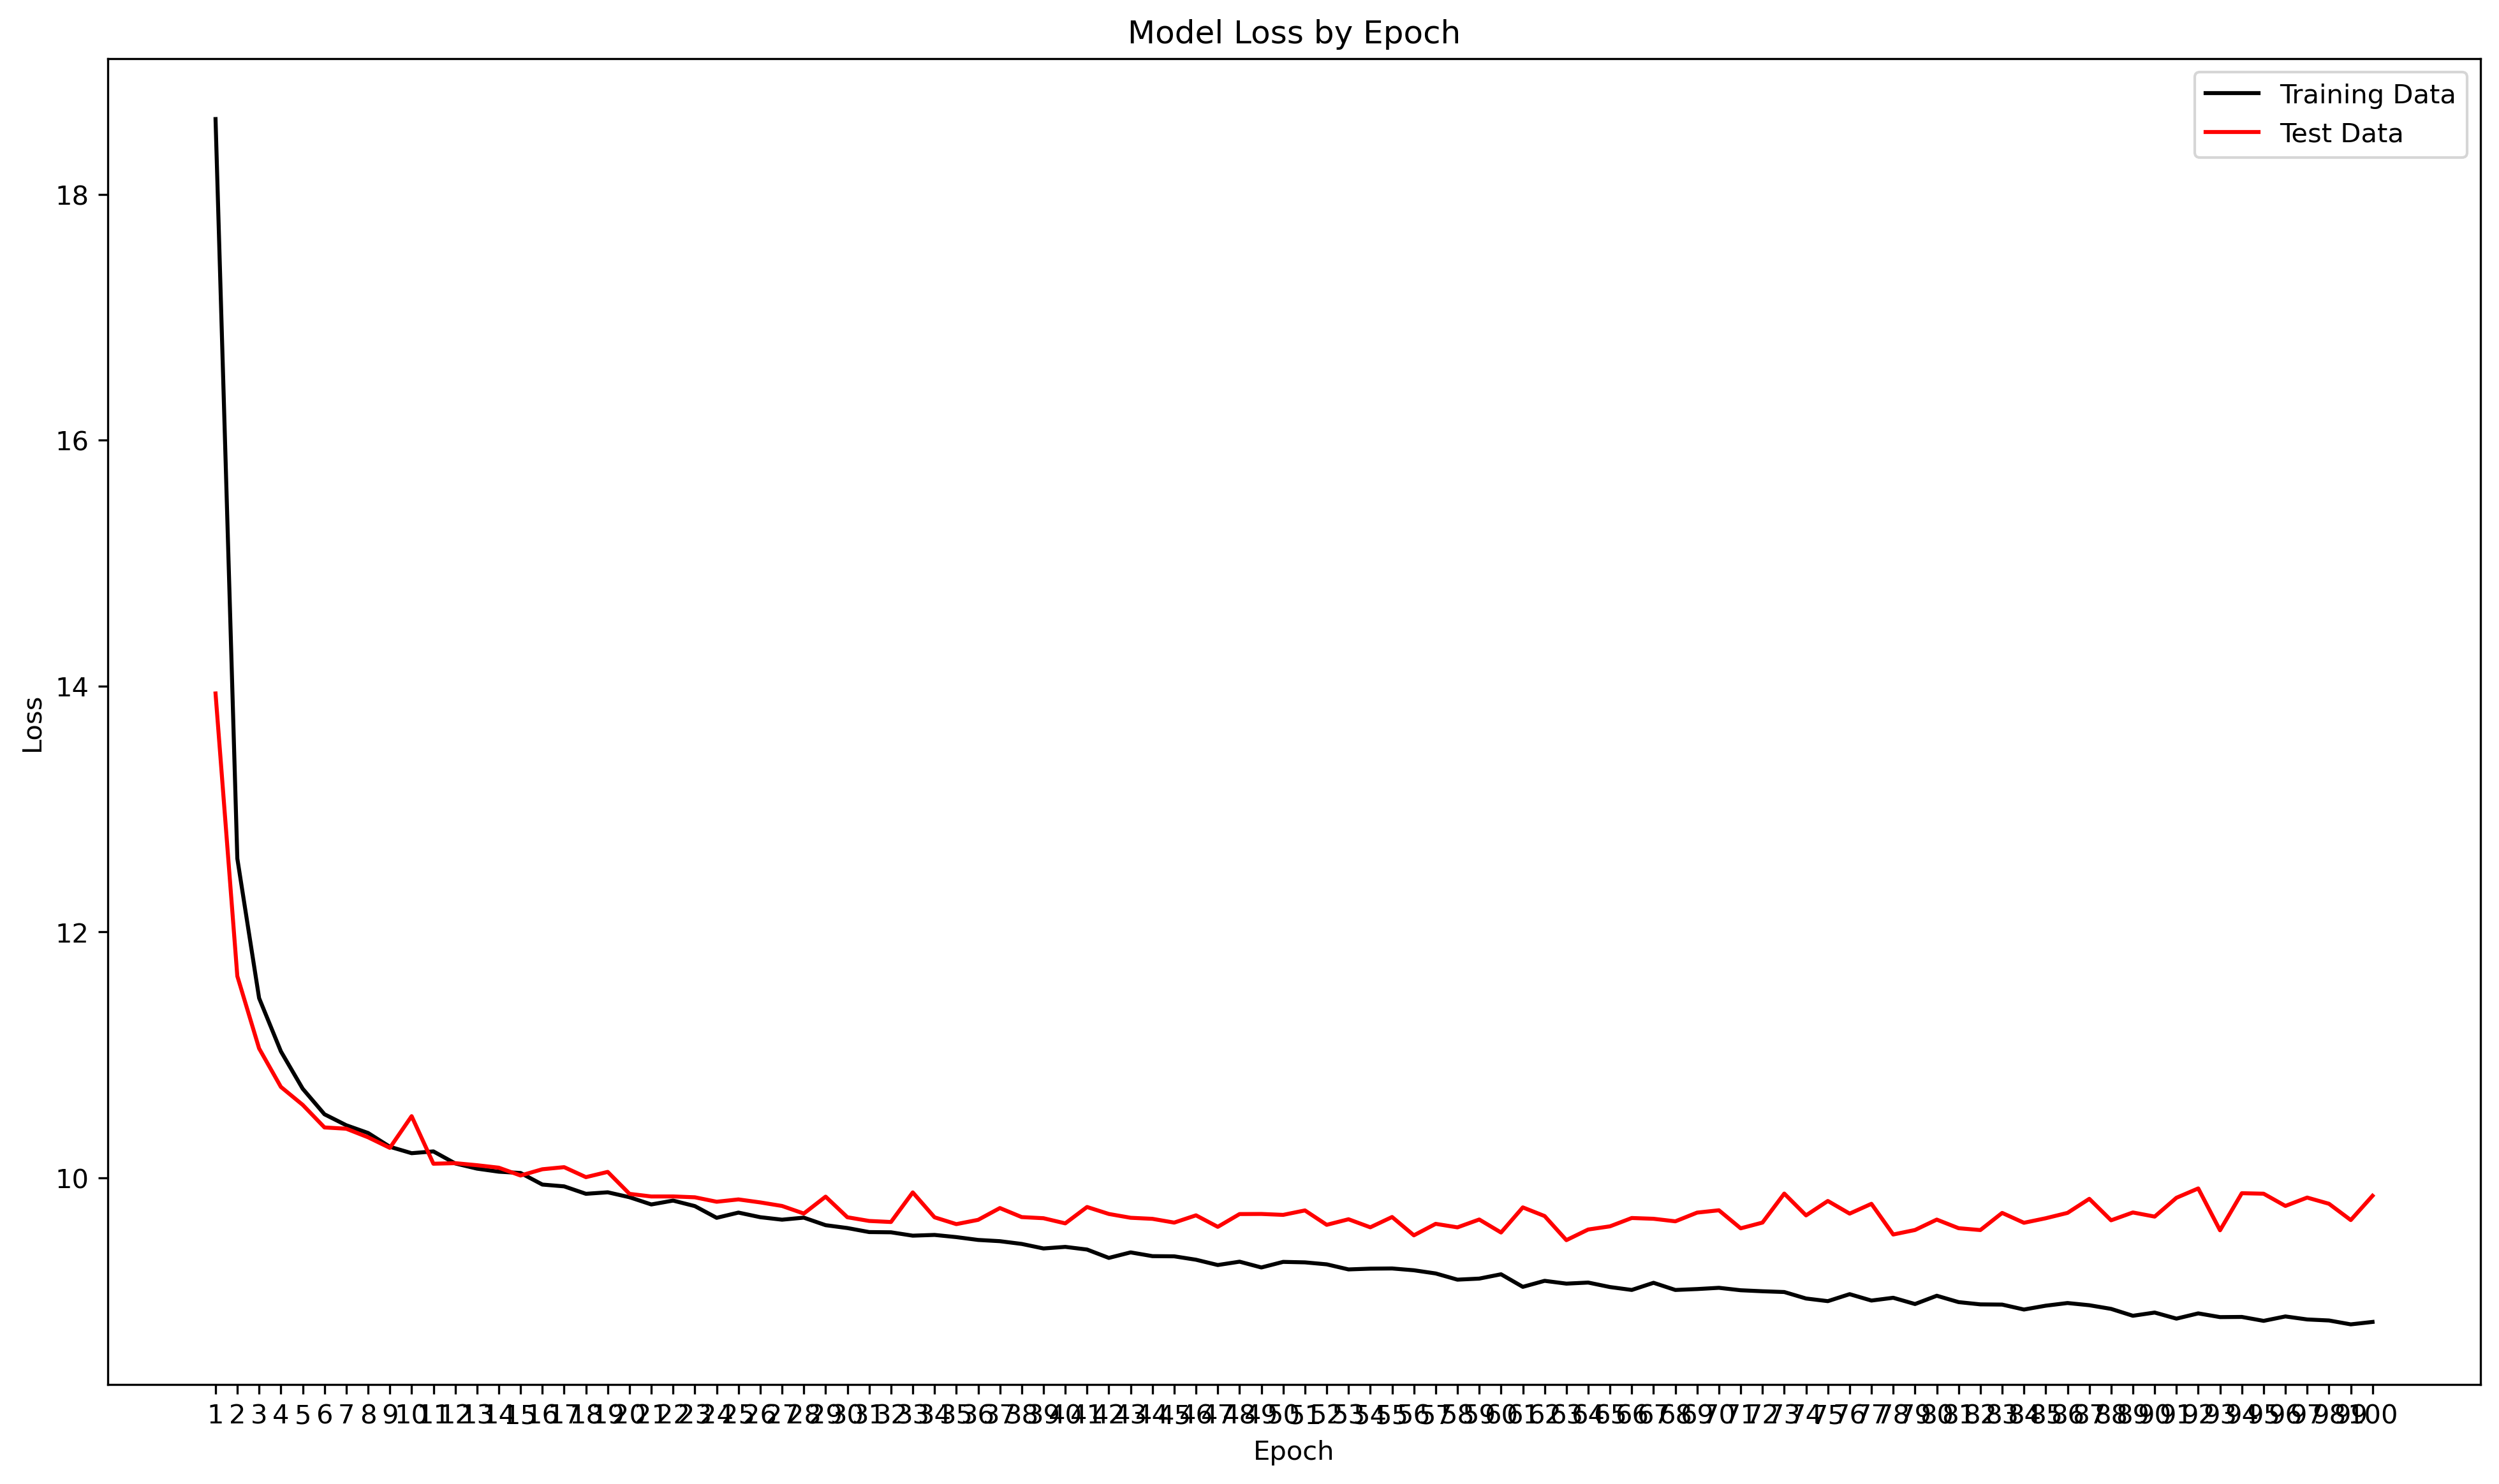

In [22]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()
fig.savefig(filepath+'loss_function.png')

**Load random weights and train on entire dataset**

In [23]:
vae.load_weights(filepath+'random_weights.h5')
vae.fit([z500_reshaped,pr_boxcox_spatial],
         epochs=epochs,
         batch_size=batch_size,
         verbose = 1)
 
[z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([z500_reshaped,pr_boxcox_spatial],batch_size=batch_size)

Epoch 1/100
197/197 [==============================] - 1s 2ms/step - loss: 15.3141
Epoch 2/100
197/197 [==============================] - 0s 2ms/step - loss: 11.6352
Epoch 3/100
197/197 [==============================] - 0s 2ms/step - loss: 10.8923
Epoch 4/100
197/197 [==============================] - 0s 2ms/step - loss: 10.6725
Epoch 5/100
197/197 [==============================] - 0s 2ms/step - loss: 10.4332
Epoch 6/100
197/197 [==============================] - 0s 2ms/step - loss: 10.3826
Epoch 7/100
197/197 [==============================] - 0s 2ms/step - loss: 10.2547
Epoch 8/100
197/197 [==============================] - 0s 2ms/step - loss: 10.2192
Epoch 9/100
197/197 [==============================] - 0s 2ms/step - loss: 10.1098
Epoch 10/100
197/197 [==============================] - 0s 2ms/step - loss: 10.0605
Epoch 11/100
197/197 [==============================] - 0s 2ms/step - loss: 10.0337
Epoch 12/100
197/197 [==============================] - 0s 2ms/step - loss: 9.9807
Ep

**Apply trained model**

In [24]:
X_encoded = encoder.predict([X,y])
X_decoded = decoder.predict(X_encoded[2])

393/393 [==============================] - 0s 327us/step


**Reconstruct flattened data to xarray lat-lon**

In [25]:
reconstructed = X_decoded.reshape(X_decoded.shape[0], inputdim2, inputdim1)
reconstructed = np.transpose(reconstructed, (0, 2, 1))
reconstructed_xr = xr.DataArray(reconstructed, coords=z500[0:X_decoded.shape[0], :, :].coords, 
                         dims=z500[0:X_decoded.shape[0], :, :].dims, attrs=z500[0:X_decoded.shape[0], :, :].attrs)

**Cluster center and odds ratio visualisation**

In [26]:
k=5
z500_clusters_vae = KMeans(n_clusters=k, random_state=0).fit(X_encoded[2])

cluster_centers_decoded = decoder.predict(z500_clusters_vae.cluster_centers_).reshape(k, inputdim2, inputdim1)
cluster_centers_decoded = np.transpose(cluster_centers_decoded, (0, 2, 1))

cluster_centers_decoded_xr = xr.DataArray(cluster_centers_decoded, coords=z500[0:k, :, :].coords, 
                         dims=z500[0:k, :, :].dims, attrs=z500[0:k, :, :].attrs)

1/1 [==============================] - 0s 9ms/step


**Relabel labels**

In [27]:
pr_labeled = cf.assign_labels(xarray_array=pr, labels=z500_clusters_vae.labels_)
pr_by_label = pr_labeled.groupby('label').mean(dim=['time', 'latitude', 'longitude'])
cluster_order = np.flip(np.argsort(pr_by_label.values)).tolist()

dict_replace = {0: cluster_order.index(0), 1: cluster_order.index(1), 2: cluster_order.index(2), 
                3: cluster_order.index(3), 4:cluster_order.index(4)}

def replace(element):
    return dict_replace.get(element, element)

vfunc = np.vectorize(replace)

relabeled_labels = vfunc(z500_clusters_vae.labels_)

d = {'Labels': 'R-VAE', 'Value': relabeled_labels}
df = pd.DataFrame(data=d)
df.to_csv(filepath+'relabeled_labels.csv')

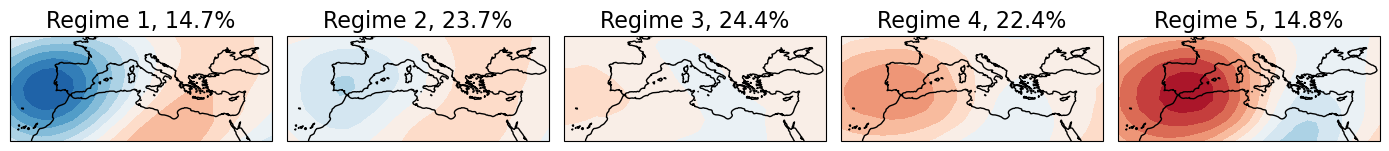

In [28]:
clusters_vis = cf.visualise_contourplot(dataset_xarray = cluster_centers_decoded_xr, 
                                                          unit = '[m]', 
                                                          cluster_results = z500_clusters_vae, 
                                        cluster_order=cluster_order,
                                                          regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                                          vmin=-1.7, vmax=1.7, steps=0.2, col_number = 5,
                                                          color_scheme = 'RdBu_r', borders=False,
                                         projection = ccrs.PlateCarree(central_longitude=0))

plt.savefig(filepath+'cluster_visualisation_5.png')

In [29]:
def calculate_conditional_probability_change(threshold_matrix, kmeans, comparison, shift_value=0):
    
    # add cluster assignment to threshold vector
    threshold_matrix_label = threshold_matrix.assign_coords(label=("time", np.roll(kmeans.labels_, shift_value)))

    # probability conditional on weather type
    n_wr = threshold_matrix_label.groupby('label').mean()

    # overall probability
    n_total = threshold_matrix_label.mean(dim='time')
    
    if comparison=='difference':
        ds = n_wr - n_total
    elif comparison=='ratio':
        ds = n_wr/n_total
    elif comparison=='none':
        ds = n_wr
    else:
        print('invalid entry for diff_or_quot')
    
    return(ds)

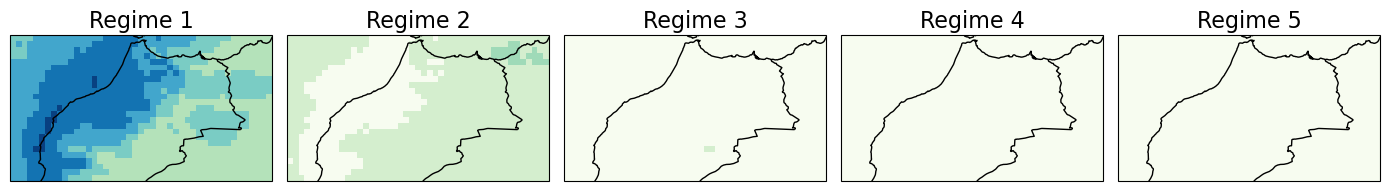

In [30]:
pr_qn95_ratio = calculate_conditional_probability_change(threshold_matrix = threshold_qn95, 
                                                        kmeans = z500_clusters_vae,
                                                       comparison = 'ratio', shift_value=0)

pr_qn95_vis = cf.visualise_spatial_oddsratio(dataset_xarray = pr_qn95_ratio, unit='',
                                               cluster_order=cluster_order,
                                   color_scheme = 'GnBu', vmin = 0, vmax=6, steps=7, 
                                   title = 'Odds ratio of 95th percentile precipitation',
                                             regime_names = ['Regime 1', 'Regime 2', 'Regime 3',
                                                                         'Regime 4', 'Regime 5', 'Regime 6',
                                                                         'Regime 7', 'Regime 8'],
                                   borders=True, projection=ccrs.PlateCarree(central_longitude=0), col_number=5)

plt.savefig(filepath+'oddsratio_95_5.png')

### regular evaluation continues

In [31]:
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
X_2d = tsne.fit_transform(X_encoded[2])

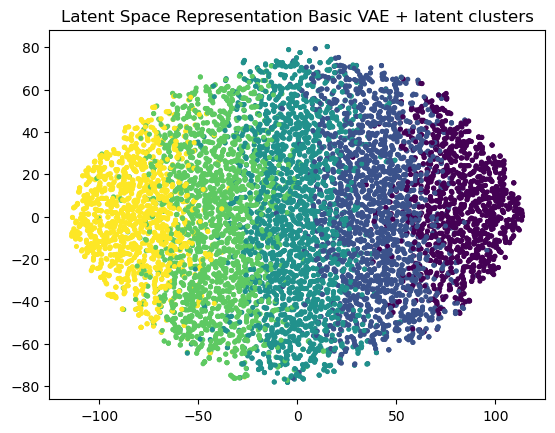

In [32]:
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=relabeled_labels, s=7)
plt.title('Latent Space Representation Basic VAE + latent clusters')
#plt.legend(*scatter.legend_elements())
plt.savefig(filepath+'tsne_latent.png')

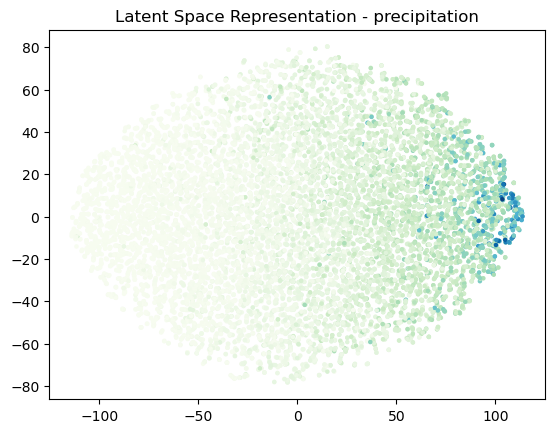

In [33]:
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=pr_spatial.values, cmap='GnBu', s=5, alpha=1)
plt.title('Latent Space Representation - precipitation')
#plt.legend(*scatter.legend_elements(), loc='upper right')
plt.savefig(filepath+'tsne_precipitation_nolegend.png')

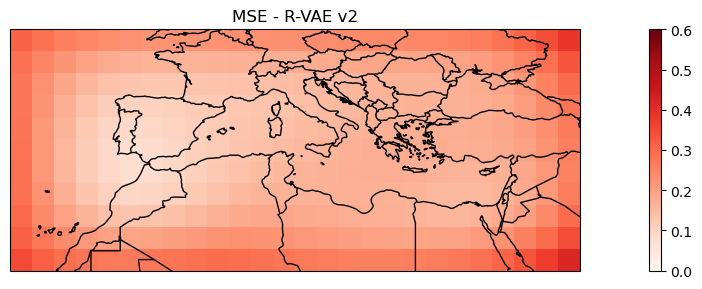

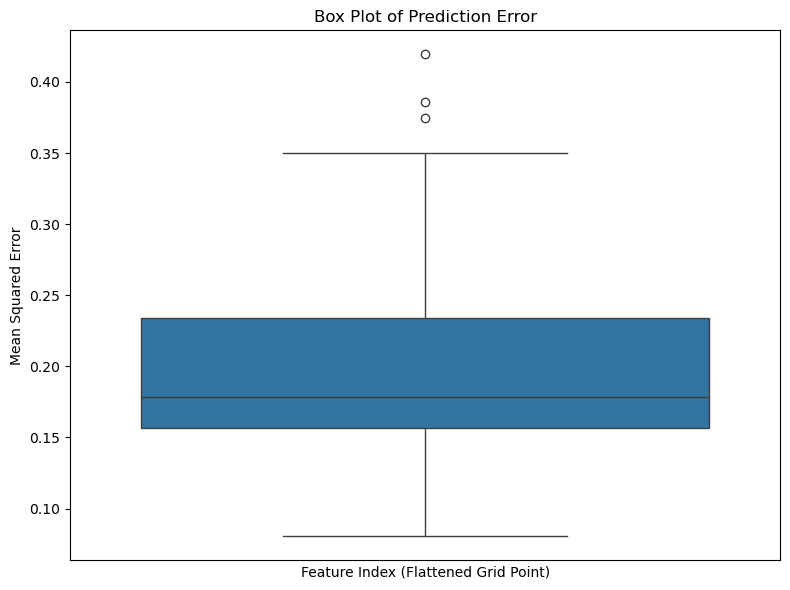

In [36]:
mse = mean_squared_error(X_decoded, z500_reshaped, multioutput='raw_values')

mse_reshaped = mse.reshape(ny,nx, order='F')
mse_reshaped_xr = xr.DataArray(mse_reshaped, coords=z500[0, :, :].coords, 
                     dims=z500[0, :, :].dims, attrs=z500[0, :, :].attrs)

fig = plt.figure(figsize=[14,3])
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))
mse_reshaped_xr.plot(ax=ax1, cmap='Reds', transform=ccrs.PlateCarree(), vmin=0, vmax=0.6)
ax1.coastlines()
ax1.add_feature(cartopy.feature.BORDERS)
ax1.set_title('MSE - R-VAE v2')
plt.tight_layout()
plt.savefig(filepath+'reconstructed_mse.png')

# Box plot of prediction error
plt.figure(figsize=(8, 6))
sns.boxplot(data=mse)
plt.title('Box Plot of Prediction Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Feature Index (Flattened Grid Point)')
plt.xticks([])
plt.tight_layout()
plt.savefig(filepath + 'predictive_mse_boxplot.png')
plt.show()